In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

from mapie.regression import MapieQuantileRegressor

SEED = 42

2024-11-29 12:42:25.082466: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-29 12:42:25.114261: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-29 12:42:25.594683: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# **Prepare data**

Load, preprocess and split data into train, test and calibration sets:

In [ ]:
data = fetch_california_housing()
X, y = data.data, data.target

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test_cal, y_train, y_test_cal = train_test_split(X, y, test_size=0.3, random_state=SEED)
X_test, X_cal, y_test, y_cal = train_test_split(X_test_cal, y_test_cal, test_size=0.5, random_state=SEED)

print('Train: ', X_train.shape, ' ', y_train.shape)
print('Test: ', X_test.shape, ' ', y_test.shape)
print('Calibration: ', X_cal.shape, ' ', y_cal.shape)

Train:  (14448, 8)   (14448,)
Test:  (3096, 8)
Calibration:  (3096, 8)


# **Train and save models**

Create, train and save Keras models:

* `model_up` with tau = (1-alpha)/2
* `model_low` with tau = alpha/2
* `model` with tau = 0.5

In [13]:
def pinball_loss(y_true, y_pred, tau=0.5):
    error = y_true - y_pred
    return tf.reduce_mean(tf.maximum(tau * error, (tau - 1) * error))

def train_and_save_model(loss_fn, file_name):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss=loss_fn)
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=.2, verbose=0)
    model.save(file_name)
    return model

alpha = .1

model_list = [
    train_and_save_model(lambda y_true, y_pred: pinball_loss(y_true, y_pred, tau=(1-alpha)/2), 'model_up.keras'),
    train_and_save_model(lambda y_true, y_pred: pinball_loss(y_true, y_pred, tau=(alpha/2)), 'model_low.keras'),  
    train_and_save_model('mse', 'model.keras')
]

/home/antonio/code/uncertainty-pinns/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/antonio/code/uncertainty-pinns/.venv/lib/python3.10/site-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:     train_and_save_model(lambda y_true, y_pred: pinball_loss(y_true, y_pred, tau=(1-alpha)/2), 'model_up.keras'),

  return {key: serialize_keras_object(value) for key, value in obj.items()}
/home/antonio/code/uncertainty-pinn

# **MAPIE**

Load and wrap for `sklearn` compatibility (the wrapper assumes that the model is already trained):

In [14]:
class TrainedKerasRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        return self

    def predict(self, X):
        return self.model.predict(X).flatten()

    def __sklearn_is_fitted__(self):
        return True


# loaded_model = load_model('model.keras')
# model = TrainedKerasRegressorWrapper(loaded_model)

model_files = ['model_low.keras', 'model_up.keras', 'model.keras']
wrapped_models = []

for file in model_files:
    loaded_model = load_model(file, compile=False)
    wrapped_model = TrainedKerasRegressorWrapper(loaded_model)
    wrapped_models.append(wrapped_model)

MAPIE quantile regression.

The list of estimators consist of:

* [0]: Estimator with quantile value of alpha/2
* [1]: Estimator with quantile value of 1 - alpha/2
* [2]: Estimator with quantile value of 0.5
```

In [15]:
mapie_regressor = MapieQuantileRegressor(
    estimator=wrapped_models, cv='prefit')

mapie_regressor.fit(X_cal, y_cal)

predictions, intervals = mapie_regressor.predict(X_test)

lower_intervals = intervals[:, 0]
upper_intervals = intervals[:, 1]

results = pd.DataFrame({
    'Prediction': predictions.flatten(),
    'Lower Interval': lower_intervals.flatten(),
    'Upper Interval': upper_intervals.flatten(),
    'Amplitude': upper_intervals.flatten() - lower_intervals.flatten(),
    'Actual Value': y_test
})

results.head()

96/97 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step

/home/antonio/code/uncertainty-pinns/.venv/lib/python3.10/site-packages/mapie/regression/quantile_regression.py:201: UserWarning: WARNING: The alpha that is set needs to be the same as the alpha of your prefitted model in the following order [alpha/2, 1 - alpha/2, 0.5]
  warnings.warn(


97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step


/home/antonio/code/uncertainty-pinns/.venv/lib/python3.10/site-packages/mapie/utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(
/home/antonio/code/uncertainty-pinns/.venv/lib/python3.10/site-packages/mapie/utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


,Prediction,Lower Interval,Upper Interval,Amplitude,Actual Value
0,1.445701,0.036668,1.871801,1.835134,1.225
1,3.240260,2.235327,4.086952,1.851625,3.204
2,4.436941,3.459247,5.216661,1.757414,4.507
3,2.843951,1.551743,3.326231,1.774488,2.343
4,1.581329,0.394638,2.156013,1.761375,1.019


# **Plot intervals**

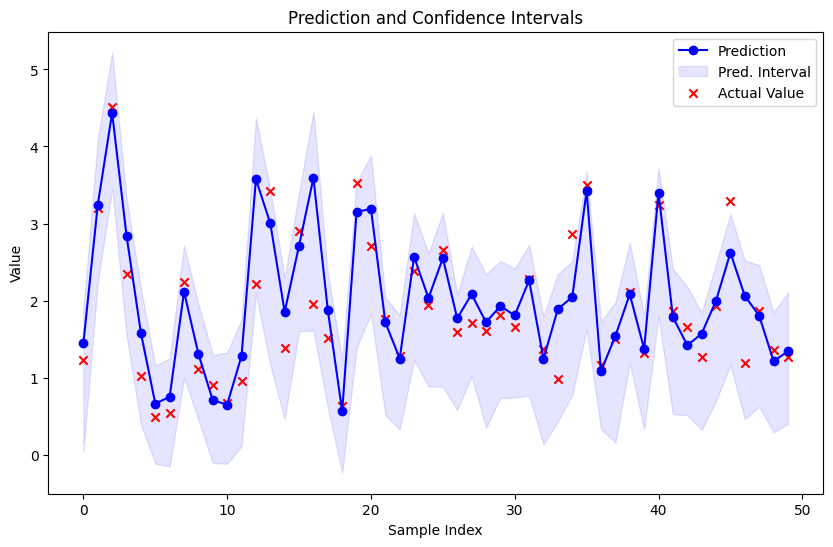

In [16]:
indices = np.arange(len(X_test))[:50]

plt.figure(figsize=(10, 6))

plt.plot(indices, results['Prediction'][:50], label='Prediction', color='blue', marker='o')
plt.fill_between(indices, results['Lower Interval'][:50], results['Upper Interval'][:50],
                 color='blue', alpha=0.1, label='Pred. Interval')
plt.scatter(indices, results['Actual Value'][:50], color='red', label='Actual Value', marker='x')

plt.title('Prediction and Confidence Intervals')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()
